# Advanced Lanes Detection

## Camera Calibration

In [1]:
# Import the necessary libraries
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [3]:
# The function cal_undistort takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
# This function makes sure that each processed image is saved in the 
# appropriate folder 
def save_img(img, folder, fname, stage_name, col_map):
    fname = fname.split('/')[1]
    fname = fname.split('.')[0]
    new_filename = fname + "_" + stage_name + '.jpg'    
    mpimg.imsave(folder + "/" + new_filename, img,cmap=col_map)

In [5]:
# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane 

# Prepare object points 
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

# Create the undistorted_images directory within the camera_cal directory
if not os.path.exists("camera_cal/undistorted_images"):
    os.makedirs("camera_cal/undistorted_images")

for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If corners are found, add object and image points 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # get the undistorted version of the calibration image
        undistorted = cal_undistort(img, objpoints, imgpoints)
        
        save_img(undistorted, "camera_cal/undistorted_images", fname, "undist", col_map = 'jet')

## Computer Vision Pipeline 

In [6]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


In [12]:
# Create the undistorted directory 
if not os.path.exists("output_images/undistorted"):
    os.makedirs("output_images/undistorted")
# Create the binary directory 
if not os.path.exists("output_images/binary"):
    os.makedirs("output_images/binary")
# Create the warped directory 
if not os.path.exists("output_images/warped"):
    os.makedirs("output_images/warped")
# Create the lane_pixels directory 
if not os.path.exists("output_images/lane_pixels"):
    os.makedirs("output_images/lane_pixels")
# Create the polynomial directory 
if not os.path.exists("output_images/polynomial"):
    os.makedirs("output_images/polynomial")

    
# This function processes each individual image coming from the video stream 
# and estimates where the lane lines are
def image_pipeline(img, fname):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    save_img(undistorted, "output_images/undistorted", fname, "undistorted", col_map = 'jet')
    
    s_thresh=(170, 255)
    sx_thresh=(20, 100)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    binary_final = sxbinary + s_binary
    save_img(binary_final, "output_images/binary", fname, "binary", col_map = 'gray')
    
    # Apply a birds-eye view's perspective transform
    src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])
    dst = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (binary_final.shape[1],binary_final.shape[0])
    warped = cv2.warpPerspective(binary_final, M, img_size, flags=cv2.INTER_LINEAR)
    save_img(warped, "output_images/warped", fname, "warped", col_map = 'gray')
    
    # Apply a sliding window search
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    save_img(output, "output_images/lane_pixels", fname, "lane_pixels", col_map = 'jet')
    
    # Apply polynomial fits to the left and right lanes
    if len(window_centroids) > 0:
        leftx = []
        lefty = []
        for (x,y), value in np.ndenumerate(l_points):
            if l_points[x,y] == 255:
                leftx.append(y)
                lefty.append(x)
        rightx = []
        righty = []
        for (x,y), value in np.ndenumerate(r_points):
            if r_points[x,y] == 255:
                rightx.append(y)
                righty.append(x) 
        
        lefty = lefty[::-1]
        righty = righty[::-1]
    
        ploty = np.linspace(0, 719, num=720)
        left_fit = np.polyfit(lefty, leftx, 2) 
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        mark_size = 3
        fig = plt.figure()
        plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
        plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis()
        fname_n = fname
        fname_n = fname_n.split('/')[1]
        fname_n = fname_n.split('.')[0]
        new_filename = fname_n + "_" + "poly" + '.jpg'  
        fig.savefig('output_images/polynomial/' + new_filename)
         
    return output

## Test Images

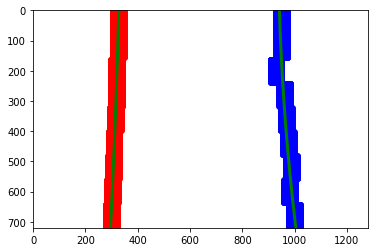

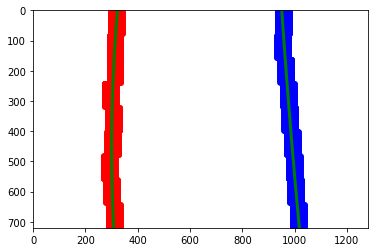

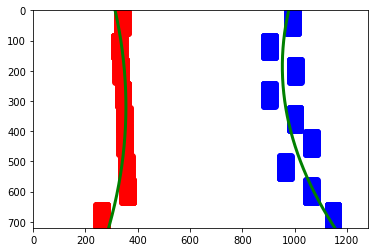

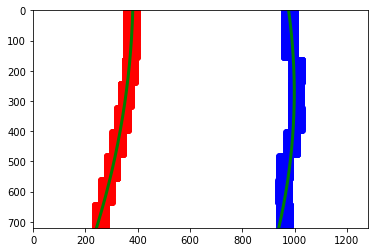

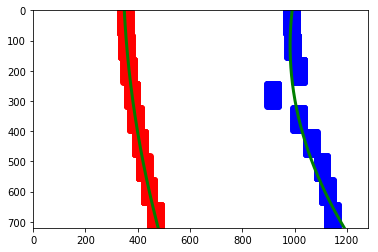

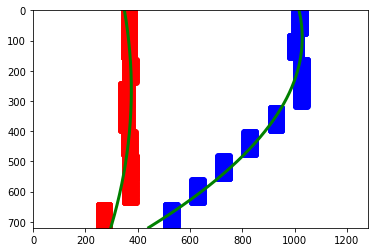

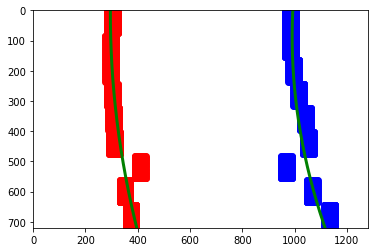

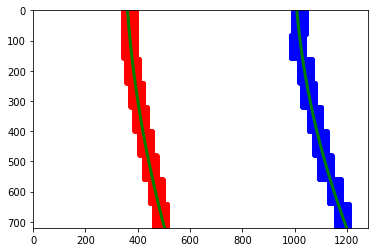

In [13]:
# Create the output_images directory 
if not os.path.exists("output_images"):
    os.makedirs("output_images")
    
# Read in and make a list of the test images
test_images = glob.glob('test_images/*.jpg')

for fname in test_images:
    # read in each image
    img = mpimg.imread(fname)
    
    result = image_pipeline(img, fname)
    
    save_img(result, "output_images", fname, "final", col_map = 'gray')